In [85]:
import os
import re
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import torch
from PIL import Image
from torchmetrics.functional import bleu_score

from models import Decoder, Encoder, ImageCaptioningModel
from plotter import plot_images
from utils import get_and_create_data, open_json, preprocess_image

In [86]:
def get_bleu_scores(
    true_captions: List[str], pred_captions: List[str], n_gram: int = 2
) -> List[float]:
    bleu_scores = []
    for tc, pc in zip(true_captions, pred_captions):
        score = bleu_score([pc], [tc], n_gram=n_gram).item()
        bleu_scores.append(score)
    return bleu_scores

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Provide the model path.

model_path = os.path.join(
    "inference", "unique_images_context_as_gate_2023-06-22T16:33:01.644886_end2end"
)
model_name = "epochs_50.pt"

config = open_json(filepath=os.path.join(model_path, "training_config.json"))
vocab = torch.load(os.path.join(model_path, "vocab.pt"))

In [88]:
# Load the models.

checkpoint = torch.load(os.path.join(model_path, model_name), map_location=device)

encoder = Encoder(
    lstm_hidden_size=config["decoder_params"]["lstm_hidden_size"],
    **config["encoder_params"],
).to(device)
decoder = Decoder(**config["decoder_params"]).to(device)

model = ImageCaptioningModel(
    encoder=encoder, decoder=decoder, start_token=config["start_token"], device=device
).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

ImageCaptioningModel(
  (encoder): Encoder(
    (CONV1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool1): MaxPool2d(kernel_size=5, stride=2, padding=1, dilation=1, ceil_mode=False)
    (CONV2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool2): MaxPool2d(kernel_size=5, stride=3, padding=1, dilation=1, ceil_mode=False)
    (CONV3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool3): MaxPool2d(kernel_size=5, stride=3, padding=1, dilation=1, ceil_mode=False)
    (H_0): Linear(in_features=10816, out_features=2048, bias=True)
    (C_0): Linear(in_features=10816, out_features=2048, bias=True)
    (activation_functi

In [89]:
# Load the test set

data_path = os.path.join(".", "data")
output_path = os.path.join(data_path, "unique_images_csv")
preprocessed_images_output_path = os.path.join(data_path, "unique_preprocessed_images")
images_path = os.path.join(data_path, "Images")
captions_path = os.path.join(data_path, "captions.txt")

training_set, validation_set, test_set = get_and_create_data(
    output_path=output_path,
    preprocessed_images_output_path=preprocessed_images_output_path,
    captions_path=captions_path,
    images_path=images_path,
    test_size=0.2,
)

In [90]:
# Get a caption for each image in the test set.

test_images = [
    Image.open(image_path).convert("RGB") for image_path in test_set["image"].tolist()
]
test_images = [preprocess_image(img).to(device) for img in test_images]

test_images_pred_captions = [
    model.caption_image(image=img, vocab=vocab, max_length=20).lower() for img in test_images
]

assert len(test_images_pred_captions) == test_set.shape[0]

In [91]:
scores = get_bleu_scores(
    true_captions=test_set["caption"].tolist(),
    pred_captions=test_images_pred_captions,
    n_gram=2,
)

In [92]:
test_set["model_caption"] = test_images_pred_captions
test_set["bleu_score"] = scores

test_set = test_set[test_set["bleu_score"] > 0]

test_set = test_set.sort_values(by="bleu_score", ascending=False)
test_set

,image,caption,lengths,model_caption,bleu_score
475,./data/unique_preprocessed_images/1189977786_4...,dog jumping into swimming pool .,6,dog jumping into pool .,0.709042
440,./data/unique_preprocessed_images/874665322_9a...,dog runs through the grass .,6,dog runs in the grass .,0.707107
494,./data/unique_preprocessed_images/3265162450_5...,three dogs running through the snow .,7,dog jumps through the snow .,0.535362
102,./data/unique_preprocessed_images/944374205_fd...,children play soccer in field .,6,three dogs play in field .,0.516398
501,./data/unique_preprocessed_images/3602838407_b...,black dog in water .,5,brown dog playing in water .,0.516398
...,...,...,...,...,...
576,./data/unique_preprocessed_images/1362128028_8...,kids play in blue tub full of water outside .,10,dog <unk> through of water .,0.162357
43,./data/unique_preprocessed_images/2584957647_4...,the white dog brings stick from the water .,9,white dog swims .,0.143252
3,./data/unique_preprocessed_images/2066048248_f...,two men and some horses on snowy mountain .,9,man <unk> up mountain .,0.142090
366,./data/unique_preprocessed_images/3621741935_5...,little girl eats ice cream near her bike .,9,person on bmx bike .,0.142090


In [93]:
test_set["image"] = [
    re.sub(r"_.\.jpg", ".jpg", image_path).replace(
        preprocessed_images_output_path, images_path
    )
    for image_path in test_set["image"].tolist()
]

In [94]:
top_k = 5

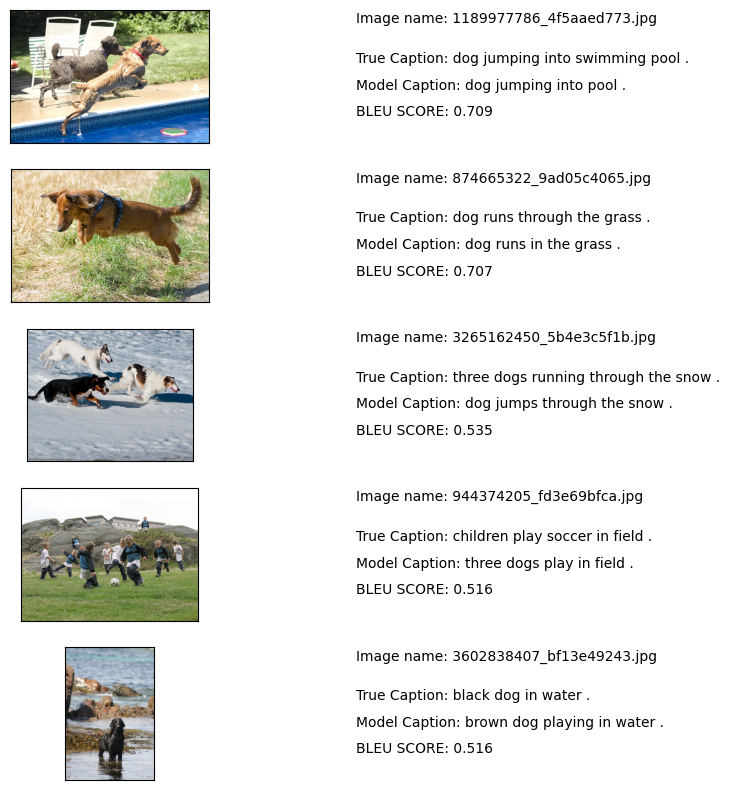

In [95]:
plot_images(df=test_set.iloc[:top_k, :], saveto="image_with_high_bleu_score.png")

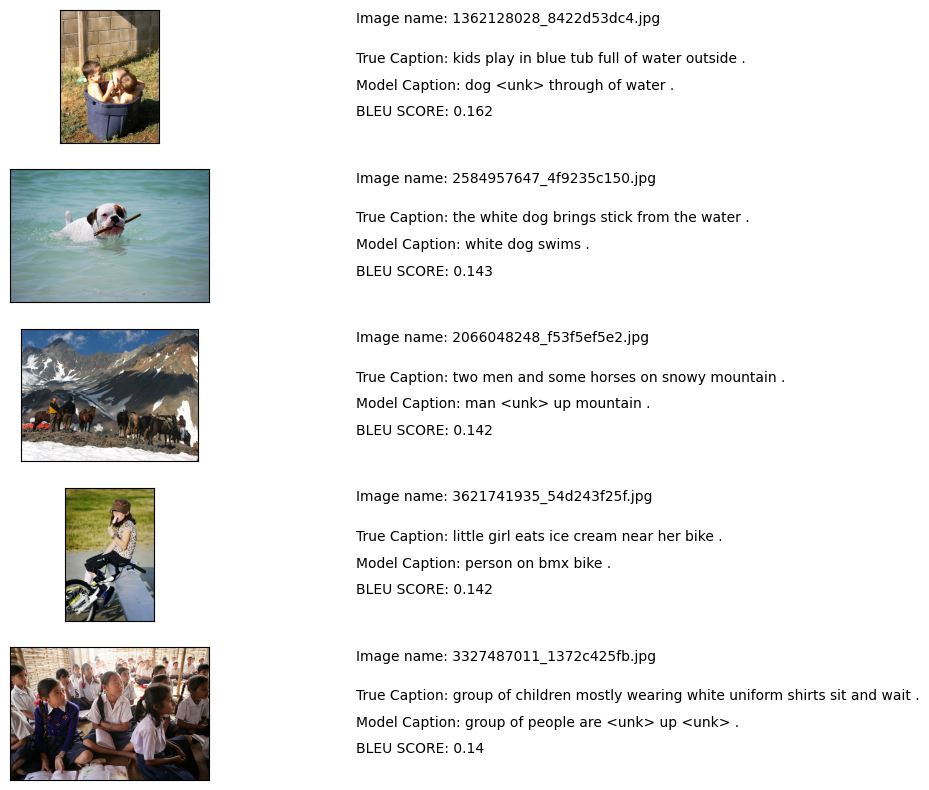

In [96]:
plot_images(df=test_set.iloc[-top_k:, :], saveto="image_with_low_bleu_score.png")